**Transfer learning**

For an example of transfer learning in TensorFlow for a computer vision task, let's use a

1. pre-trained model from TensorFlow's Keras Applications,
2. fine-tune it on a smaller dataset,
3. improve its performance for a specific task.
4. This example will demonstrate how to adapt a MobileNetV2 model, pre-trained on ImageNet, for a new classification task using the CIFAR-10 dataset—a collection of 60,000 32x32 color images in 10 different classes.

**Step 1: Import Libraries and Load Data**

In [1]:
# Import libraries:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load the dataset:
(x_train, y_train),(x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [3]:
# Normalize pixel values and convert labels to one-hot encoding:
x_train,x_test = x_train/255.0,x_test/255.0
y_train,y_test = to_categorical(y_train,10),to_categorical(y_test,10)

**Data Augmentation:**

Data augmentation is a strategy used in machine learning to increase the diversity and amount of training data without actually collecting new data. This is achieved by creating modified versions of the existing data. For example, in image data, augmentation techniques might include rotation, scaling, flipping, cropping, or adding noise.

Data augmentation is beneficial for several reasons:

1. Preventing Overfitting: By providing more varied data, the model is less likely to memorize the training data and more likely to generalize to new, unseen data.
2. Improving Model Performance: More data generally leads to better model performance, especially in deep learning.
3. Dealing with Imbalanced Data: Augmentation can help balance the dataset by creating more instances of under-represented classes.

Remember, the type of augmentation should make sense for the problem at hand. For example, flipping an image might be fine for a general object recognition task, but not for a task where orientation is crucial, like reading numbers or letters.

**Step 2: Preprocess Data**

Since MobileNetV2 expects input images of size 224x224, and CIFAR-10 images are 32x32, we need to resize them. We'll also apply some data augmentation:

In [4]:
# Data Augmentation:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    fill_mode='nearest')

datagen.fit(x_train)

**Step 3: Modify Pre-trained Model**

We'll load MobileNetV2 without its top layer (since we're applying it to a new task with 10 classes instead of 1000), add a new classifier on top, and freeze the layers of MobileNetV2:

****We use less classes than 1000****

In [6]:
# Load the MobileNetV2 without the top layer:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Freeze thr base model:
base_model.trainable = False

# Add custome layers on top for our task:
x = base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x)              # New FC layer, random init
predictions = Dense(10,activation='softmax')(x) # New softmax layer

# Define the model:
model = Model(inputs=base_model.input, outputs=predictions)

/tmp/ipython-input-6-3645316852.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32,32,3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Step 4: Compile and Train the Model**

In [11]:
%%time
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model:
history = model.fit(datagen.flow(x_train,y_train,batch_size=32),
                    steps_per_epoch=int(len(x_train)/32),
                    epochs=10,
                    validation_data=(x_test,y_test),
                    verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 132s 80ms/step - accuracy: 0.2689 - loss: 1.9980 - val_accuracy: 0.3244 - val_loss: 1.8609
Epoch 2/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:06 43ms/step - accuracy: 0.3125 - loss: 1.9402

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.3125 - loss: 1.9402 - val_accuracy: 0.3250 - val_loss: 1.8608
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.3141 - loss: 1.8848 - val_accuracy: 0.3373 - val_loss: 1.8269
Epoch 4/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:04 42ms/step - accuracy: 0.2500 - loss: 1.9134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.2500 - loss: 1.9134 - val_accuracy: 0.3374 - val_loss: 1.8265
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 121s 71ms/step - accuracy: 0.3261 - loss: 1.8525 - val_accuracy: 0.3372 - val_loss: 1.8268
Epoch 6/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:05 42ms/step - accuracy: 0.4688 - loss: 1.6709

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.4688 - loss: 1.6709 - val_accuracy: 0.3364 - val_loss: 1.8287
Epoch 7/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 136s 74ms/step - accuracy: 0.3373 - loss: 1.8282 - val_accuracy: 0.3452 - val_loss: 1.8111
Epoch 8/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:47 69ms/step - accuracy: 0.3750 - loss: 1.8614

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3750 - loss: 1.8614 - val_accuracy: 0.3453 - val_loss: 1.8110
Epoch 9/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 114s 73ms/step - accuracy: 0.3332 - loss: 1.8308 - val_accuracy: 0.3514 - val_loss: 1.7907
Epoch 10/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 1:04 41ms/step - accuracy: 0.3750 - loss: 1.7711

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.3750 - loss: 1.7711 - val_accuracy: 0.3520 - val_loss: 1.7905
CPU times: user 16min 3s, sys: 31.8 s, total: 16min 35s
Wall time: 11min 44s


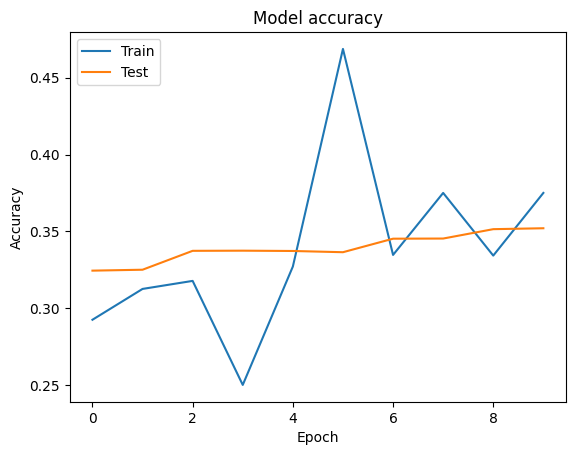

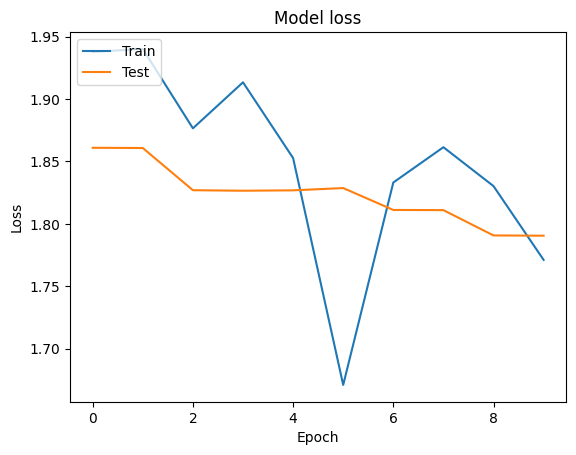

In [12]:
import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



**An extra run with more epochs and Increased Batch Size**

Epoch 1/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 101s 122ms/step - accuracy: 0.3453 - loss: 1.7986 - val_accuracy: 0.3563 - val_loss: 1.7820
Epoch 2/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3906 - loss: 1.6781 - val_accuracy: 0.3559 - val_loss: 1.7818
Epoch 3/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 131s 121ms/step - accuracy: 0.3470 - loss: 1.7903 - val_accuracy: 0.3568 - val_loss: 1.7797
Epoch 4/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3438 - loss: 1.8559 - val_accuracy: 0.3572 - val_loss: 1.7792
Epoch 5/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 95s 121ms/step - accuracy: 0.3466 - loss: 1.7919 - val_accuracy: 0.3566 - val_loss: 1.7853
Epoch 6/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.3750 - loss: 1.7652 - val_accuracy: 0.3553 - val_loss: 1.7837
Epoch 7/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 103s 132ms/step - accuracy: 0.3451 - loss: 1.7995 - val_accuracy: 0.3576 - val_loss: 1.7708
Epoch 8/50
781/781 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.3125 - loss: 2.

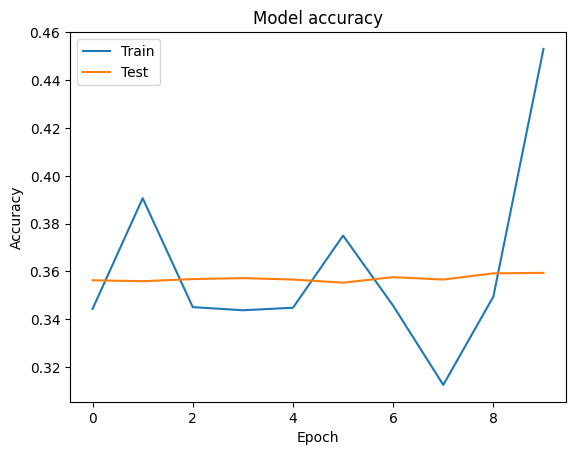

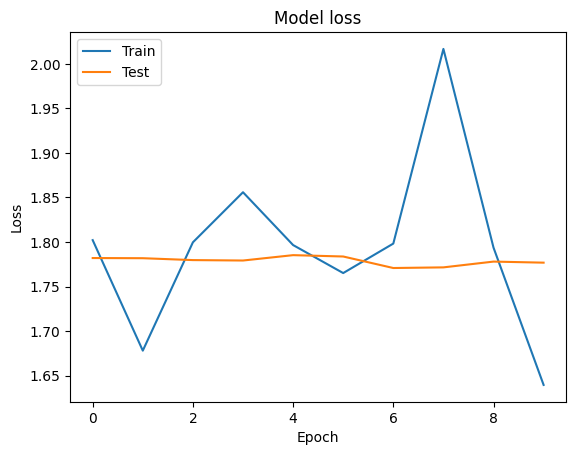

CPU times: user 13min 44s, sys: 24.8 s, total: 14min 9s
Wall time: 10min 24s


In [16]:
%%time
# Early stopping:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',patience=3, restore_best_weights=True)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model:
history = model.fit(datagen.flow(x_train,y_train, batch_size=64),
                    steps_per_epoch=int(len(x_train) / 64),
                    epochs=50,
                    validation_data=(x_test,y_test),
                    verbose=1,
                    callbacks=[early_stopping])


import matplotlib.pyplot as plt
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


**Step 5: Fine-Tuning (Optional)**

After the initial training with the top layers, you can choose to unfreeze some of the bottom layers of the MobileNetV2 model and continue training to improve accuracy. Before doing so, it's important to recompile the model:

In [23]:
# Unfreeze some layers in the base model
base_model.trainable = True
fine_tune_at = 100  # This is the number of layers from the top to freeze
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                         steps_per_epoch=int(len(x_train) / 32), epochs=5,
                         validation_data=(x_test, y_test), verbose=1)

Epoch 1/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 273s 163ms/step - accuracy: 0.3733 - loss: 1.8092 - val_accuracy: 0.4601 - val_loss: 1.5513
Epoch 2/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4062 - loss: 1.5019 - val_accuracy: 0.4594 - val_loss: 1.5513
Epoch 3/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 291s 156ms/step - accuracy: 0.4675 - loss: 1.4998 - val_accuracy: 0.5615 - val_loss: 1.2543
Epoch 4/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6875 - loss: 1.1006 - val_accuracy: 0.5610 - val_loss: 1.2547
Epoch 5/5
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 245s 157ms/step - accuracy: 0.5160 - loss: 1.3608 - val_accuracy: 0.5980 - val_loss: 1.1743


This example demonstrates the basics of applying transfer learning with TensorFlow to improve performance on a computer vision task using a smaller dataset. Fine-tuning and data augmentation are powerful techniques to increase accuracy further and adapt the pre-trained model to the new task more effectively.

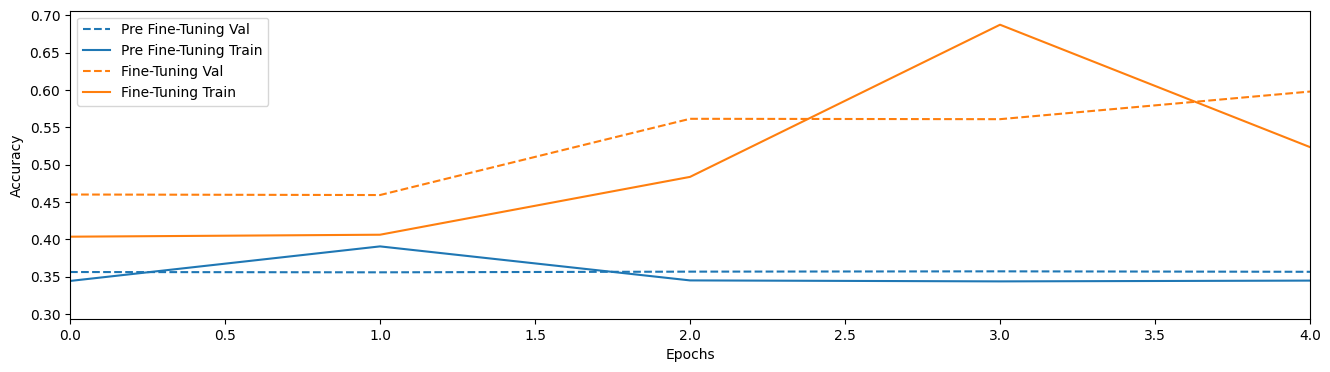

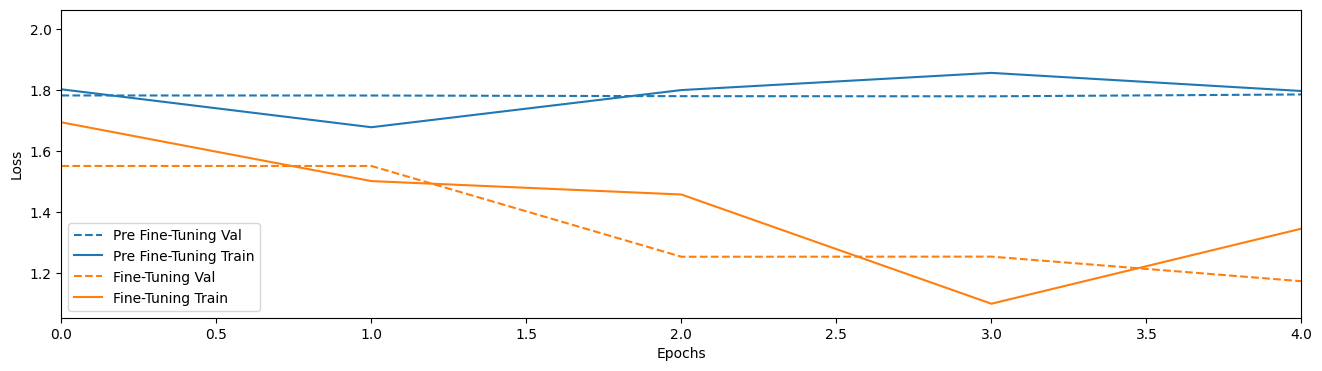

In [24]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16, 4))

    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    plt.xlim([0, max(history.epoch)])

# Plot accuracy
plot_history([('Pre Fine-Tuning', history),
              ('Fine-Tuning', history_fine)],
             key='accuracy')

# Plot loss
plot_history([('Pre Fine-Tuning', history),
              ('Fine-Tuning', history_fine)],
             key='loss')